In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.utils import class_weight
from keras_preprocessing import image as im
tf.random.set_seed(
    5
)

# Loading data

In [3]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations

In [4]:
images, annotations = load_data("../../../../images/", '../../../../emo-at-cap.csv')

In [5]:
import pickle

In [6]:
with open('emotion_features.pl', 'rb') as f:
    emotion_features = pickle.load(f)

# Processing of data

In [7]:
import nltk

In [8]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [9]:
tokenized = [tokenizer.tokenize(i) for i in annotations]

In [10]:
unique_tokens, unique_counts = np.unique(np.hstack(tokenized), return_counts=True)

In [11]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.hstack(tokenized)), np.hstack(tokenized))

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=["'" ',' '-' ... 'youth' 'исходный' 'текст'], y=['the' 'man' 'is' ... 'with' 'some' 'clothes'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [12]:
frequency = sorted(list(zip(unique_tokens, unique_counts)), key = lambda x: x[1])[::-1][:50]

In [13]:
frequency

[('the', 3261),
 ('is', 2031),
 ('man', 1905),
 ('and', 1536),
 ('woman', 1361),
 ('are', 1036),
 ('a', 963),
 ('to', 891),
 ('looks', 751),
 ('happy', 705),
 ('with', 547),
 ('something', 480),
 ('men', 478),
 ('of', 463),
 ('two', 408),
 ('other', 361),
 ('people', 343),
 ('couple', 334),
 (',', 330),
 ('in', 278),
 ('look', 270),
 ('because', 265),
 ('they', 256),
 ('about', 247),
 ('on', 246),
 ('at', 192),
 ('trying', 190),
 ('serious', 189),
 ('women', 184),
 ('each', 179),
 ('together', 176),
 ('by', 175),
 ('having', 171),
 ('flirting', 165),
 ('he', 155),
 ('smiling', 151),
 ('arguing', 141),
 ('angry', 140),
 ('scared', 138),
 ('worried', 137),
 ('hugging', 135),
 ('surprised', 134),
 ('calm', 133),
 ('company', 131),
 ('her', 129),
 ('group', 123),
 ('for', 121),
 ('she', 117),
 ('looking', 117),
 ('his', 115)]

In [14]:
len(unique_tokens)

2162

In [15]:
pad_token = '<PAD>'
start_token = '<S>'
end_token = '<E>'

In [16]:
vocab = dict(zip(unique_tokens,list(range(3,len(unique_tokens)+3))))
vocab[pad_token] = 0
vocab[start_token] = 1
vocab[end_token] = 2

In [17]:
inverse_vocab = dict([(v,k) for k,v in vocab.items()])

In [18]:
def padd(sentences, pad_token, start_token, end_token, maxlen=10):
    padded_sentences = []
    for i in sentences:
        sentence = [start_token] + i + [end_token]
        if len(sentence)>=maxlen+2:
            sentence = sentence[:maxlen+2]
        else:
            sentence = sentence+[pad_token for i in range(maxlen+2-len(sentence))]
        padded_sentences.append(sentence)
    return padded_sentences

In [19]:
padded_sentences = padd(tokenized, pad_token, start_token, end_token, maxlen=10)

In [20]:
np.mean([len(i) for i in padded_sentences])

12.0

In [21]:
indexed = list(map(lambda x: [vocab[i] for i in x],padded_sentences))

In [22]:
images.shape

(3840, 224, 224, 3)

In [23]:
len(class_weights)

2162

In [24]:
class_weights = list(class_weights)
class_weights.insert(0, 1)
class_weights.insert(1, 1)
class_weights.insert(2, 1)

In [25]:
len(class_weights), len(vocab)

(2165, 2165)

In [26]:
class_weights[:4]

[1, 1, 1, 0.21013259327782918]

In [27]:
class_weights = np.array(class_weights)

In [28]:
class_weights.shape

(2165,)

# Model with transfer learning

In [29]:
def calc_size(x, f, s, padding='same'):
    p = 2 if padding=='same' else 1
    return (x-f+2)/s+1

### Convolutional model

In [30]:
import tensorflow.keras.applications as apps


In [136]:
class ConvEncoder(tf.keras.Model):
    def __init__(self):
        super(ConvEncoder, self).__init__()
        #building resnet
        self.resnet_extractor = apps.ResNet152V2(include_top=False, weights='imagenet')
        self.resnet_extractor.trainable = False
        self.pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.dense1 = tf.keras.layers.Dense(units=256, activation='relu')

    def call(self, input):
        extracted = self.pooling(self.resnet_extractor(input))
        return self.dense1(extracted)

In [137]:
conv_encoder = ConvEncoder()

In [138]:
conv_res = conv_encoder(np.expand_dims(images[0],axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [139]:
conv_res

<tf.Tensor: shape=(1, 256), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.3356801 , 0.16574502,
        0.        , 0.06465492, 0.14414412, 0.451162  , 0.        ,
        1.0860741 , 0.9117526 , 1.0798895 , 1.2178807 , 0.        ,
        0.7440634 , 0.        , 0.        , 0.        , 0.64324963,
        0.2066977 , 0.        , 0.07643223, 0.        , 0.27555907,
        1.0308704 , 0.        , 1.1361771 , 0.33863866, 1.0292271 ,
        0.        , 0.3339634 , 0.9932029 , 1.1174693 , 0.        ,
        0.        , 0.8203671 , 0.18498412, 0.        , 1.7884114 ,
        1.0417131 , 0.828557  , 0.        , 1.6460681 , 0.        ,
        0.08498424, 0.        , 0.        , 0.        , 0.75868607,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.17114162, 1.5702498 , 0.        , 0.        , 0.09601158,
        1.4980857 , 1.3335825 , 0.515349  , 0.        , 0.        ,
        0.        , 0.        , 0.54992366, 0.7877711 , 0.        

### LSTM model

### making w2v embeddings

In [35]:
!pip install gensim

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [36]:
import gensim.downloader as api

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [37]:
w2v_embeddings = api.load('word2vec-google-news-300')

In [38]:
def build_embeddings(vocab, word_vectors, embed_dim):
    emb_matrix = np.zeros(shape=(len(vocab)+ 1 , embed_dim), dtype='float32')
    count = 0
    for word, i in vocab.items():
        try:
            emb_matrix[i, :] = word_vectors.get_vector(word)
        except:
            count += 1
            emb_matrix[i, :] = np.random.uniform(-0.1, 0.1, embed_dim)
    print('{} words are out of vocabulary：'.format(count))
    return emb_matrix


In [39]:
w2v_embeddings = build_embeddings(vocab, w2v_embeddings, 300)

22 words are out of vocabulary：


### attention

In [140]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

### building model

In [141]:
class LSTMDecoder(tf.keras.Model):
    def __init__(self, max_tokens, units=512, embeddings=None, dim=128):
        super(LSTMDecoder, self).__init__()
        self.units = units
        self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=dim, name='embeddings',
                                                   weights=[embeddings])
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.lstm = tf.keras.layers.LSTM(units=self.units, return_state=True, return_sequences=True, name='lstm_decoder', 
                                         recurrent_dropout=0.1,recurrent_initializer='glorot_uniform')
        self.intermidiate_dense = tf.keras.layers.Dense(units=self.units, activation='relu')
        self.output_dense = tf.keras.layers.Dense(units=max_tokens)
        self.attention = BahdanauAttention(self.units)

    def call(self, input, features, hidden, state_c, emo_feature):
        embedded = self.dropout(self.embeddings(input))
        context_vector, attention_weights = self.attention(features, hidden)
        concated = tf.concat([tf.expand_dims(context_vector, 1), embedded, tf.expand_dims(emo_feature, 1)], axis=-1)
        result_lstm, state_h, state_c = self.lstm(concated, initial_state=[hidden, state_c])
        intermidiate_dense = self.intermidiate_dense(result_lstm)
        intermidiate_dense = tf.reshape(intermidiate_dense, (-1, intermidiate_dense.shape[2]))
        logits = self.output_dense(intermidiate_dense)
        return logits, state_h, state_c, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [142]:
lstm_decoder = LSTMDecoder(len(inverse_vocab), 256, w2v_embeddings, dim=300)

### emotion decoder

In [143]:
class EmotionEncoder(tf.keras.Model):
    def __init__(self, units=512):
        super(EmotionEncoder, self).__init__()
        self.h = tf.keras.layers.Dense(units=units, activation='relu')
        self.c = tf.keras.layers.Dense(units=units, activation='relu')

    def call(self, emotion_feature):
        
        return self.h(emotion_feature), self.c(emotion_feature)
 

In [144]:
emotion_encoder = EmotionEncoder(256)

In [145]:
emotion_encoder(np.expand_dims(emotion_features[0],axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(<tf.Tensor: shape=(1, 256), dtype=float32, numpy=
 array([[0.        , 0.03763812, 0.04546275, 0.        , 0.        ,
         0.01950219, 0.02638444, 0.00773892, 0.07961226, 0.        ,
         0.        , 0.        , 0.        , 0.02093898, 0.        ,
         0.04067344, 0.09176856, 0.        , 0.        , 0.        ,
         0.        , 0.0536245 , 0.03718359, 0.0481756 , 0.        ,
         0.        , 0.00505926, 0.        , 0.        , 0.        ,
         0.        , 0.06781891, 0.        , 0.0083142 , 0.01871156,
         0.        , 0.        , 0.04517783, 0.02082223, 0.0352021 ,
         0.06312175, 0.        , 0.01949755, 0.        , 0.04266611,
         0.        , 0.00016937, 0.03865726, 0.        , 0.00174433,
         0.        , 0.00123261, 0.04392024, 0.        , 0.02766182,
         0.03417677, 0.02115616, 0.01493243, 0.0049016 , 0.00815593,
         0.        , 0.        , 0.01056174, 0.        , 0.01452143,
         0.        , 0.01913444, 0.        , 0.     

### Training

In [146]:
from sklearn.model_selection import train_test_split

In [147]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',
                                                                         from_logits=True)
lr_value = 1e-4
reduction_power = 10
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_value)
with_weights = False

In [148]:
epochs = 30
batch_size = 64
patience_epochs = 2

In [149]:
def loss_function(real, pred, loss_weights):
        mask = tf.math.logical_not(tf.math.equal(real, vocab[pad_token]))
        loss_ = loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_weights = tf.cast(loss_weights, dtype=loss_.dtype)
        loss_*=loss_weights
        return loss_

In [177]:
@tf.function
def train_step(image, target, emo_feature, lengths, optimizer):
    with tf.GradientTape() as tape:
        features = conv_encoder(image)
        hidden, state_c = emotion_encoder(emo_feature)

        # Teacher forcing - feeding the target as the next input
        batched_loss = []
        for t in range(1, target.shape[1]):
            
            dec_input = tf.expand_dims(target[:, t-1], 1)
            result, hidden, state_c, _ = lstm_decoder(dec_input, features, hidden, state_c,emo_feature)
            weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
            weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
            batched_loss.append(loss_function(target[:, t], result, weights))
        batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
        batched_loss = tf.reduce_sum(batched_loss, axis=1)
        lengths = tf.cast(lengths, dtype=batched_loss.dtype)
        loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)

    variables = conv_encoder.trainable_variables + lstm_decoder.trainable_variables + emotion_encoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss, perplexity

In [178]:
@tf.function
def evaluate(image, target,emo_feature, lengths, optimizer):
    hidden, state_c = emotion_encoder(emo_feature)

    features = conv_encoder(image)
    # Teacher forcing - feeding the target as the next input
    batched_loss = []
    for t in range(1, target.shape[1]):

        dec_input = tf.expand_dims(target[:, t-1], 1)
        result, hidden, state_c, _ = lstm_decoder(dec_input, features, hidden, state_c, emo_feature)
        weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
        weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
        batched_loss.append(loss_function(target[:, t], result, weights))
    
    batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
    batched_loss = tf.reduce_sum(batched_loss, axis=1)
    lengths = tf.cast(lengths, dtype=batched_loss.dtype)
    loss = tf.reduce_mean(batched_loss / lengths)
    perplexity = tf.exp(loss)


    return loss, perplexity

In [170]:
train_images, val_images, train_sequences, val_sequences, train_emo, val_emo =  train_test_split(images, indexed, emotion_features, test_size=0.2, random_state=10)
val_images, test_images, val_sequences, test_sequences, val_emo, test_emo =  train_test_split(val_images, val_sequences,val_emo, test_size=0.5, random_state=10)

In [171]:
train_length = (np.array(train_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [172]:
val_length = (np.array(val_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [173]:
test_length = (np.array(test_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [174]:
train_images = np.array(np.array_split(train_images, len(train_images)//batch_size)).astype('float32')
test_images = np.array(np.array_split(test_images, len(test_images)//batch_size)).astype('float32')
val_images = np.array(np.array_split(val_images, len(val_images)//batch_size)).astype('float32')

train_emo = np.array(np.array_split(train_emo, len(train_emo)//batch_size)).astype('float32')
test_emo = np.array(np.array_split(test_emo, len(test_emo)//batch_size)).astype('float32')
val_emo = np.array(np.array_split(val_emo, len(val_emo)//batch_size)).astype('float32')

train_sequences = np.array(np.array_split(train_sequences, len(train_sequences)//batch_size))
test_sequences = np.array(np.array_split(test_sequences, len(test_sequences)//batch_size))
val_sequences = np.array(np.array_split(val_sequences, len(val_sequences)//batch_size))

train_length = np.array(np.array_split(train_length, len(train_length)//batch_size)).astype('float32')
test_length = np.array(np.array_split(test_length, len(test_length)//batch_size)).astype('float32')
val_length = np.array(np.array_split(val_length, len(val_length)//batch_size)).astype('float32')


In [175]:
train_images.shape, train_sequences.shape, train_length.shape, train_emo.shape

((48, 64, 224, 224, 3), (48, 64, 12), (48, 64), (48, 64, 7))

In [86]:
!pip install tqdm

  Using cached tqdm-4.61.2-py2.py3-none-any.whl (76 kB)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [87]:
if not with_weights:
    class_weights = np.array([1 for i in range(len(class_weights))])

In [88]:
from tqdm import tqdm

In [179]:
train_loss = []
train_perplexity = []
val_loss = []
val_perplexity = []
overfit_epochs = 0
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_perplexity = 0
    epoch_val_loss = 0
    epoch_val_perplexity = 0
    for batch_train_images, batch_train_sequences, batched_train_length, batched_train_emo in tqdm(zip(train_images,train_sequences,train_length, train_emo)):
        batched_train_loss, batched_train_perplexity = train_step(batch_train_images,batch_train_sequences,batched_train_emo, batched_train_length, optimizer)
        epoch_train_loss+=batched_train_loss
        epoch_train_perplexity+=batched_train_perplexity
    epoch_train_loss = epoch_train_loss/train_images.shape[0]
    epoch_train_perplexity = epoch_train_perplexity/train_images.shape[0]
    train_loss.append(epoch_train_loss)
    train_perplexity.append(epoch_train_perplexity)
    print('Finished epoch {}; Train loss : {}; Train perplexity : {}'.format(epoch,epoch_train_loss,epoch_train_perplexity))
    for batch_val_images, batch_val_sequences, batched_val_length, batched_test_emo in zip(val_images,val_sequences,val_length, val_emo):
        batched_val_loss, batched_val_perplexity = evaluate(batch_val_images, batch_val_sequences, batched_test_emo, batched_val_length, optimizer)
        epoch_val_loss+=batched_val_loss
        epoch_val_perplexity+=batched_val_perplexity
    epoch_val_loss = epoch_val_loss/val_images.shape[0]
    epoch_val_perplexity = epoch_val_perplexity/val_images.shape[0]
    val_perplexity.append(epoch_val_perplexity)
    val_loss.append(epoch_val_loss)
    print('Validation loss : {}; Validation perplexity : {}'.format(epoch_val_loss,epoch_val_perplexity))
    if len(val_loss)>=2 and val_loss[-2]<val_loss[-1]:
        overfit_epochs+=1
    else:
        overfit_epochs=0
    if overfit_epochs==patience_epochs:
        lr_value/=reduction_power
        optimizer.lr.assign(lr_value)
        print('There was no improvement in validation loss for {} epochs, thus reducing learning rate'.format(patience_epochs))

48it [01:18,  1.64s/it]


Finished epoch 0; Train loss : 7.44605016708374; Train perplexity : 2646.327880859375
Validation loss : 6.1060004234313965; Validation perplexity : 453.7125244140625


48it [00:47,  1.00it/s]


Finished epoch 1; Train loss : 5.789498805999756; Train perplexity : 330.68951416015625
Validation loss : 5.714325428009033; Validation perplexity : 306.7153625488281


48it [00:47,  1.00it/s]


Finished epoch 2; Train loss : 5.581444263458252; Train perplexity : 268.03228759765625
Validation loss : 5.594034194946289; Validation perplexity : 272.21337890625


48it [00:48,  1.00s/it]


Finished epoch 3; Train loss : 5.413810729980469; Train perplexity : 226.7266845703125
Validation loss : 5.454564571380615; Validation perplexity : 237.05535888671875


48it [00:48,  1.01s/it]


Finished epoch 4; Train loss : 5.252772808074951; Train perplexity : 193.0530548095703
Validation loss : 5.335048198699951; Validation perplexity : 210.48170471191406


48it [00:48,  1.01s/it]


Finished epoch 5; Train loss : 5.107113361358643; Train perplexity : 166.82894897460938
Validation loss : 5.213046550750732; Validation perplexity : 186.4616241455078


48it [00:48,  1.01s/it]


Finished epoch 6; Train loss : 4.969766139984131; Train perplexity : 145.58116149902344
Validation loss : 5.110049724578857; Validation perplexity : 168.4003143310547


48it [00:48,  1.00s/it]


Finished epoch 7; Train loss : 4.8330464363098145; Train perplexity : 127.051513671875
Validation loss : 5.0705671310424805; Validation perplexity : 162.44569396972656


48it [00:48,  1.01s/it]


Finished epoch 8; Train loss : 4.702624320983887; Train perplexity : 111.51219940185547
Validation loss : 4.901880264282227; Validation perplexity : 137.24539184570312


48it [00:48,  1.00s/it]


Finished epoch 9; Train loss : 4.571197986602783; Train perplexity : 97.84622192382812
Validation loss : 4.875864028930664; Validation perplexity : 134.3500213623047


48it [00:51,  1.07s/it]


Finished epoch 10; Train loss : 4.451480388641357; Train perplexity : 86.80743408203125
Validation loss : 4.698462963104248; Validation perplexity : 112.1812515258789


48it [00:52,  1.10s/it]


Finished epoch 11; Train loss : 4.334532737731934; Train perplexity : 77.21623992919922
Validation loss : 4.629523754119873; Validation perplexity : 105.00079345703125


48it [00:48,  1.02s/it]


Finished epoch 12; Train loss : 4.226802349090576; Train perplexity : 69.43781280517578
Validation loss : 4.528106212615967; Validation perplexity : 94.83978271484375


48it [00:48,  1.00s/it]


Finished epoch 13; Train loss : 4.12919282913208; Train perplexity : 62.933231353759766
Validation loss : 4.443572044372559; Validation perplexity : 87.27922821044922


48it [00:48,  1.00s/it]


Finished epoch 14; Train loss : 4.042227745056152; Train perplexity : 57.78289794921875
Validation loss : 4.401548862457275; Validation perplexity : 84.1372299194336


48it [00:48,  1.00s/it]


Finished epoch 15; Train loss : 3.960115671157837; Train perplexity : 53.15586853027344
Validation loss : 4.33203649520874; Validation perplexity : 78.5009994506836


48it [00:48,  1.00s/it]


Finished epoch 16; Train loss : 3.8854801654815674; Train perplexity : 49.39152145385742
Validation loss : 4.244001865386963; Validation perplexity : 71.75760650634766


48it [00:48,  1.00s/it]


Finished epoch 17; Train loss : 3.8157167434692383; Train perplexity : 46.01228713989258
Validation loss : 4.216319561004639; Validation perplexity : 69.92074584960938


48it [00:47,  1.00it/s]


Finished epoch 18; Train loss : 3.750231981277466; Train perplexity : 43.12263488769531
Validation loss : 4.1453857421875; Validation perplexity : 65.24781036376953


48it [00:48,  1.00s/it]


Finished epoch 19; Train loss : 3.6942710876464844; Train perplexity : 40.76609802246094
Validation loss : 4.143374443054199; Validation perplexity : 65.44165802001953


48it [00:48,  1.01s/it]


Finished epoch 20; Train loss : 3.6374666690826416; Train perplexity : 38.51799392700195
Validation loss : 4.064839839935303; Validation perplexity : 60.283447265625


48it [00:48,  1.01s/it]


Finished epoch 21; Train loss : 3.5841434001922607; Train perplexity : 36.51634216308594
Validation loss : 4.038229465484619; Validation perplexity : 58.8861198425293


48it [00:48,  1.01s/it]


Finished epoch 22; Train loss : 3.5328118801116943; Train perplexity : 34.683414459228516
Validation loss : 4.017344951629639; Validation perplexity : 57.51198959350586


48it [00:48,  1.00s/it]


Finished epoch 23; Train loss : 3.4903786182403564; Train perplexity : 33.253841400146484
Validation loss : 3.9532787799835205; Validation perplexity : 54.00715637207031


48it [00:48,  1.01s/it]


Finished epoch 24; Train loss : 3.4442341327667236; Train perplexity : 31.743940353393555
Validation loss : 3.9307994842529297; Validation perplexity : 52.85758590698242


48it [00:48,  1.01s/it]


Finished epoch 25; Train loss : 3.403632164001465; Train perplexity : 30.480806350708008
Validation loss : 3.915989637374878; Validation perplexity : 52.16469192504883


48it [00:48,  1.01s/it]


Finished epoch 26; Train loss : 3.362133026123047; Train perplexity : 29.230194091796875
Validation loss : 3.893991470336914; Validation perplexity : 51.08392333984375


48it [00:48,  1.01s/it]


Finished epoch 27; Train loss : 3.323732614517212; Train perplexity : 28.130537033081055
Validation loss : 3.857680559158325; Validation perplexity : 49.1314582824707


48it [00:48,  1.01s/it]


Finished epoch 28; Train loss : 3.289405584335327; Train perplexity : 27.18096923828125
Validation loss : 3.829559087753296; Validation perplexity : 47.93450927734375


48it [00:48,  1.01s/it]


Finished epoch 29; Train loss : 3.253570795059204; Train perplexity : 26.212158203125
Validation loss : 3.8169775009155273; Validation perplexity : 47.200897216796875


# Viewing and saving results

In [180]:
df = pd.DataFrame()
model_name = 'conv_lstm_logits_transfer_learning_w2v_fixed_size_attention_emotions'
df['train_perplexity'] = [i.numpy() for i in train_perplexity]
df['val_perplexity'] = [i.numpy() for i in val_perplexity]
df['train_loss'] = [i.numpy() for i in train_loss]
df['val_loss'] = [i.numpy() for i in val_loss]


In [181]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

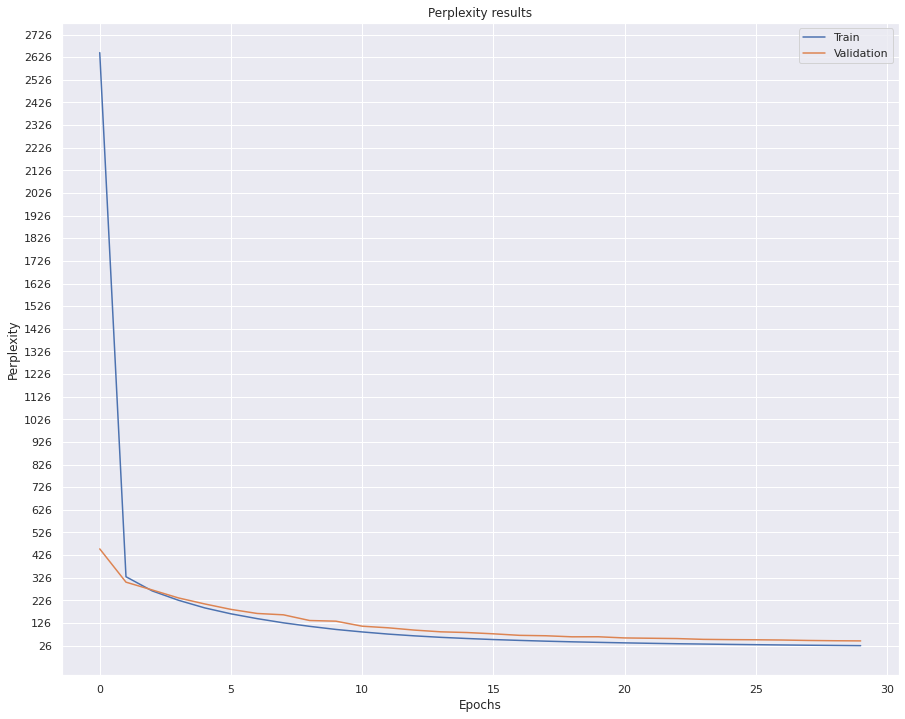

In [182]:
plt.figure(figsize=(15,12))
plt.title('Perplexity results')
plt.plot(df['train_perplexity'])
plt.plot(df['val_perplexity'])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.yticks(np.arange(min(df['train_perplexity']), max(df['train_perplexity'])+100,100))
plt.legend(['Train', 'Validation']);

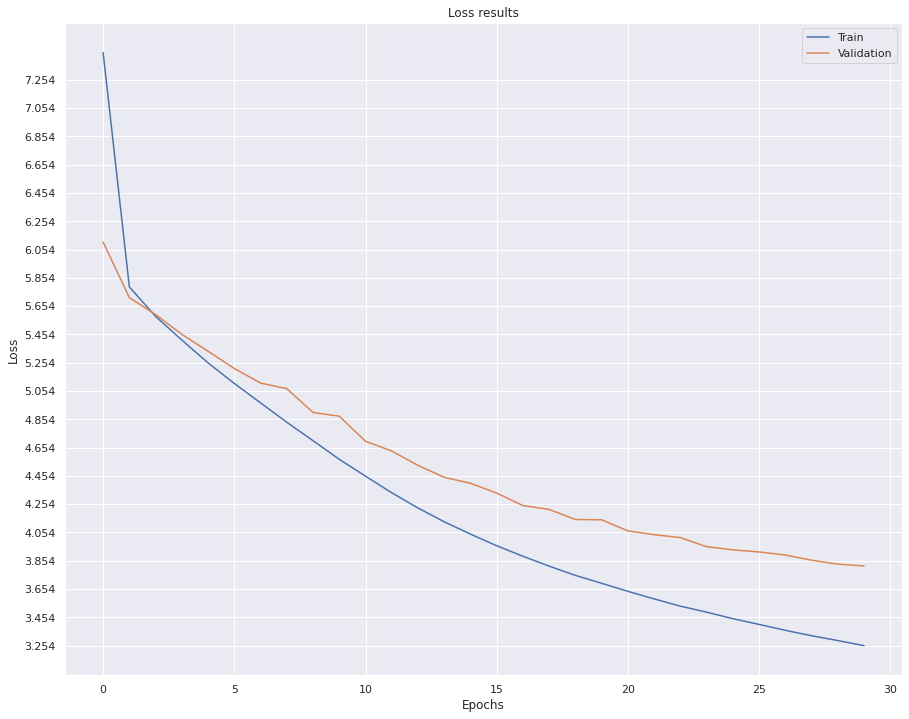

In [183]:
plt.figure(figsize=(15,12))
plt.title('Loss results')
plt.plot(df['train_loss'])
plt.plot(df['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['train_loss']),max(df['train_loss']),0.2))
plt.legend(['Train', 'Validation']);

# Testing model

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns

In [210]:
class Decoder:
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = None,
                 units:int = 256):
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len if max_len else 100
        self.start_token = start_token
        self.end_token = end_token
        self.units = units

    def decode(self, input):
        pass


class GreedyDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 emo_encoder:tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 units:int = 256
                 ):
        
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len,
                         units
                         )
        self.emo_encoder = emo_encoder

    def decode(self, input, emo_feature):
        features = self.encoder(np.expand_dims(input, axis=0))
        emo_feature = np.expand_dims(emo_feature,axis=0)
        hidden, state_c = self.emo_encoder(emo_feature)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = self.start_token
        res = []
        while True:
            # Sample a token
            output, hidden, state_c, _ = self.decoder(target_seq,features,hidden,state_c,emo_feature)
            sampled_token_index = np.argmax(tf.nn.softmax(output.numpy()))
            if len(res) > self.max_len or sampled_token_index == self.end_token:
                break

            res.append(sampled_token_index)

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

       
        return res


In [221]:
class BeamSearchDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                  emo_encoder:tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 units:int = 256
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len,
                         units
                         )
        self.emo_encoder = emo_encoder


    def decode(self, input, emo_feature, beam_size=3):
        start = [self.start_token]
        features = self.encoder(np.expand_dims(input,axis=0))
        emo_feature = np.expand_dims(emo_feature,axis=0)
        hidden, state_c = self.emo_encoder(emo_feature)
        start_word = [[start, 0.0, hidden, state_c]]

        while len(start_word[0][0]) < self.max_len:
            temp = []
            for s in start_word:
                target_seq = np.array([[s[0][-1]]])
                hidden = s[-1]
                state_c = s[-2]
                output, hidden, state_c, _ = self.decoder(target_seq, features, hidden, state_c, emo_feature)
                output = np.hstack(output)
                output = tf.nn.softmax(output).numpy()
                word_preds = np.argsort(output)[-beam_size:]

                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += output[w]
                    temp.append([next_cap, prob, hidden, state_c])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_size:]

        start_word = start_word[-1][0]

        final_caption = []

        for i in start_word:
            if i != self.end_token:
                final_caption.append(i)
            else:
                break
        return final_caption[1:]

In [212]:
def predict(data, emo_feature, decoder, inverse_vocab,
           beam_size=None):
    if beam_size:
        result = decoder.decode(data, emo_feature, beam_size=beam_size)
    else:
        result = decoder.decode(data, emo_feature)
    return ' '.join([inverse_vocab[i] for i in result])

In [222]:
greedy_decoder = GreedyDecoder(conv_encoder, lstm_decoder,emotion_encoder, vocab[start_token], vocab[end_token],
             max_len=10, units=256)

In [223]:
beam_decoder = BeamSearchDecoder(conv_encoder, lstm_decoder,emotion_encoder, vocab[start_token], vocab[end_token],
             max_len=10, units=256)

In [224]:
images.shape

(3840, 224, 224, 3)

In [261]:
idx = np.random.choice(range(len(images)))
sample = images[idx]

the group of people are laughing


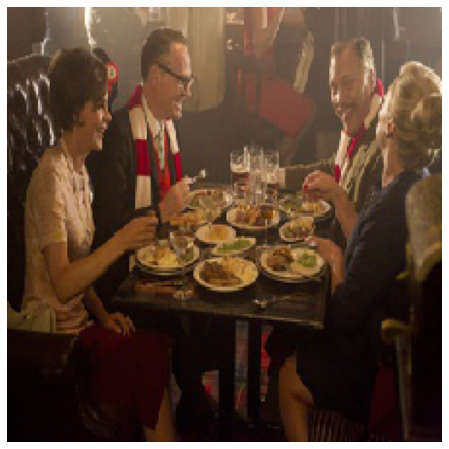

In [262]:
plt.figure(figsize=(8,8))
plt.imshow(sample)
plt.grid([])
plt.axis('off');
print(annotations[idx])

In [263]:
predict(sample, emotion_features[idx], greedy_decoder, inverse_vocab)

'the man looks woman looks woman looks woman looks woman looks'

In [264]:
predict(sample,emotion_features[idx], beam_decoder, inverse_vocab, beam_size=3)

'the man is happy to woman'

In [265]:
predict(sample,emotion_features[idx], beam_decoder, inverse_vocab, beam_size=5)

'the man is trying to the woman'

In [266]:
predict(sample,emotion_features[idx], beam_decoder, inverse_vocab, beam_size=7)

'the man is trying to the woman'

In [267]:
predict(sample,emotion_features[idx], beam_decoder, inverse_vocab, beam_size=10)

'the man is trying to the woman'

# Blue score calculation

In [268]:
from nltk.translate.bleu_score import sentence_bleu


### making predictions on test dataset with beam_size of 5

In [270]:
test_predictions = []
for batch_image, batch_emo in tqdm(zip(test_images, test_emo)):
    for image, emo in zip(batch_image, batch_emo):
        result = predict(image, emo, beam_decoder, inverse_vocab, beam_size=5)
        test_predictions.append(result)

6it [05:37, 56.17s/it]


In [271]:
test_predictions = [i.split(' ') for i in test_predictions]

In [272]:
reshaped_sequences = test_sequences.reshape(test_sequences.shape[0]*test_sequences.shape[1],-1)

In [273]:
test_sentences = []
for i in reshaped_sequences:
    tmp = []
    for word in i:
        if word!=0 and word!=1 and word!=2:
            tmp.append(inverse_vocab[word])
    test_sentences.append(tmp)

In [274]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction))
print('Overall bleu score on test data : {}'.format(np.mean(bleu_score)))
df['overall_bleu'] = np.mean(bleu_score)*100

Overall bleu score on test data : 0.00925130106249421


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

In [275]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(1,)))
print('Bleu score on test data for n-gram = 1 : {}'.format(np.mean(bleu_score)))
df['n1_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 1 : 0.23009516569528835


In [276]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,1)))
print('Bleu score on test data for n-gram = 2 : {}'.format(np.mean(bleu_score)))
df['n2_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 2 : 0.08536539216025803


In [277]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,1)))
print('Bleu score on test data for n-gram = 3 : {}'.format(np.mean(bleu_score)))
df['n3_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 3 : 0.03450833305919363


In [278]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,0,1)))
print('Bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['n4_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 4 : 0.006279449878388107


In [279]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0.25,0.25,0.25,0.25)))
print('Acuumulated bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['acc_bleu'] = np.mean(bleu_score)*100

Acuumulated bleu score on test data for n-gram = 4 : 0.00925130106249421


In [280]:
df.head()

,train_perplexity,val_perplexity,train_loss,val_loss,overall_bleu,n1_bleu,n2_bleu,n3_bleu,n4_bleu,acc_bleu
0,2646.327881,453.712524,7.446050,6.106000,0.92513,23.009517,8.536539,3.450833,0.627945,0.92513
1,330.689514,306.715363,5.789499,5.714325,0.92513,23.009517,8.536539,3.450833,0.627945,0.92513
2,268.032288,272.213379,5.581444,5.594034,0.92513,23.009517,8.536539,3.450833,0.627945,0.92513
3,226.726685,237.055359,5.413811,5.454565,0.92513,23.009517,8.536539,3.450833,0.627945,0.92513
4,193.053055,210.481705,5.252773,5.335048,0.92513,23.009517,8.536539,3.450833,0.627945,0.92513


In [281]:
df.to_csv('{}_logs.csv'.format(model_name),index=False)

In [88]:
conv_encoder.save_weights('{}_encoder.h5'.format(model_name))

In [89]:
lstm_decoder.save_weights('{}_decoder.h5'.format(model_name))